# LLM Lab4

## Shusrith S
## PES1UG22AM155

# Data Loading

The data was loaded and unnecessary columns were dropped

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
df = pd.read_csv(f"ielts_writing_dataset.csv")
df = shuffle(df)
df.drop(["Examiner_Commen", "Task_Response", "Coherence_Cohesion", "Lexical_Resource", "Range_Accuracy", "Task_Type"], axis=1, inplace=True)
df

# Preprocessing

An input column was created with the format 

Question : ... Answer :


In [4]:
df["input"] = "Question: " + df["Question"] + "\nAnswer: " + df["Essay"]
df.drop(["Question", "Essay"], axis=1, inplace=True)
df

,Overall,input
1041,4.5,Question: Write about the following topic.It i...
900,6.0,Question: The graphs below show the types of m...
1405,6.0,Question: Some people prefer to spend their li...
811,6.5,Question: The Internet is now used all around ...
221,7.0,Question: Write about the following topic.Some...
...,...,...
639,6.5,Question: Individuals can do nothing to improv...
679,7.5,Question: In some countries people spend long ...
68,6.0,Question: The world health organization recomm...
1319,8.0,Question: Even though experts believe that wal...


# Shifting the classes

A mapping was created between the scores and 14 classes starting from 0 and replaced in the original data

In [6]:
classes = sorted(dict(df["Overall"].value_counts()).keys())
mapping = {j: i for i, j in enumerate(classes)}
df["Overall"] = df["Overall"].replace(mapping)
df["Overall"] = df["Overall"].astype(int)
df

,Overall,input
1041,4,Question: Write about the following topic.It i...
900,7,Question: The graphs below show the types of m...
1405,7,Question: Some people prefer to spend their li...
811,8,Question: The Internet is now used all around ...
221,9,Question: Write about the following topic.Some...
...,...,...
639,8,Question: Individuals can do nothing to improv...
679,10,Question: In some countries people spend long ...
68,7,Question: The world health organization recomm...
1319,11,Question: Even though experts believe that wal...


# Model used


`bert-base-uncased` is the model used 

In [1]:
from transformers import BertTokenizer, AutoModelForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=14)

2025-03-24 06:26:25.750075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 06:26:25.757732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742777785.767771    3872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742777785.770748    3872 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 06:26:25.781097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Tokenization

The input is tokenized used the model's inbuilt tokenizer and input ids and attention masks are stored. 

In [7]:
df["input_id"] = df["input"].apply(lambda x: tokenizer(x, return_tensors="pt", padding="max_length", truncation=True, max_length=512)["input_ids"])
df["attention_mask"] = df["input"].apply(lambda x: tokenizer(x, return_tensors="pt", padding="max_length", truncation=True, max_length=512)["attention_mask"])
df

,Overall,input,input_id,attention_mask
1041,4,Question: Write about the following topic.It i...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
900,7,Question: The graphs below show the types of m...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1405,7,Question: Some people prefer to spend their li...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
811,8,Question: The Internet is now used all around ...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
221,9,Question: Write about the following topic.Some...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...
639,8,Question: Individuals can do nothing to improv...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
679,10,Question: In some countries people spend long ...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
68,7,Question: The world health organization recomm...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1319,11,Question: Even though experts believe that wal...,"[[tensor(101), tensor(3160), tensor(1024), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


# Custom dataset

A custom dataset is created to give input id, attention mask and labels each iteration. 90% of the data is used for training and 10% for validation, loaded in a dataloader

In [8]:
import torch
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].squeeze(0) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings["input_id"])


train_dataset = Dataset({"input_id": df["input_id"][:1200].tolist(), "attention_mask": df["attention_mask"][:1200].tolist()}, df["Overall"][:1200].tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
test_dataset = Dataset({"input_id": df["input_id"][1200:].tolist(), "attention_mask": df["attention_mask"][1200:].tolist()}, df["Overall"][1200:].tolist())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

# LoRA config

LoRA is applied on the query and key layers only because of the design of the BERT model. Scaling factor of 32 and rank reduction factor of 8 is used with a dropout of 0.4. 305k of 109M parameters are trainable, using only 27.8% of the parameters and reducing computation overhead. 

In [10]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "key"],
    lora_dropout=0.4,
    bias="none",
    task_type="SEQ_CLS",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 305,678 || all params: 109,798,684 || trainable%: 0.2784


# PyTorch Lightning Module

A pytorch lightning module is created for finetuning purposes with an AdamW optimizer having a learning rate of `5e-5`

In [11]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau

class IETLSClassifier(pl.LightningModule):
    def __init__(self, model, lr=5e-5, num_classes=14):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = torch.nn.CrossEntropyLoss()

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, input_id, attention_mask, labels=None):
        output = self.model(input_ids=input_id, attention_mask=attention_mask, labels=labels)
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_id']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        loss, logits = self(input_ids, attention_mask, labels)

        preds = torch.argmax(logits, dim=1)
        acc = self.train_acc(preds, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_acc", acc, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_id']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        loss, logits = self(input_ids, attention_mask, labels)

        preds = torch.argmax(logits, dim=1)
        acc = self.val_acc(preds, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

        scheduler = {
            "scheduler": ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}


# Training

The model is trained for 30 epochs.

In [12]:
classifier = IETLSClassifier(model)

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=1
)
model.config.problem_type = "single_label_classification"
trainer.fit(classifier, train_loader, test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                               | Params | Mode 
-------------------------------------------------------------------------
0 | model     | PeftModelForSequenceClassification | 109 M  | train
1 | loss_fn   | CrossEntropyLoss                   | 0      | train
2 | train_acc | MulticlassAccuracy                 | 0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
torch.save(classifier.model.state_dict(), "finetuned_model.pth")

# Evaluation function

A function is created which tokenizes the input, gets the prediction and returns the band score

In [9]:
def inference(text):
    with torch.no_grad():
        input_id = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
        output = model(input_id["input_ids"], input_id["attention_mask"])
        return torch.argmax(output.logits, dim=1).item()

# Loading saved model

In [10]:
from peft import LoraConfig, get_peft_model

a = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=14
)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "key"],
    lora_dropout=0.4,
    bias="none",
    task_type="SEQ_CLS",
)

a = get_peft_model(a, lora_config)
a.load_state_dict(torch.load("finetuned_model.pth", weights_only=True))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

# Predictions on evaluation data

Val accuracy is 68.75%

In [11]:
a.eval()
a.cuda()
x = next(iter(test_loader))
id, mask = x["input_id"].cuda(), x["attention_mask"].cuda()
z = x["labels"].cuda()
with torch.no_grad():
    output = a(id, mask)
preds = torch.argmax(output.logits, dim=1)
correct = (preds == z).sum().item()
id = id.cpu()
mask = mask.cpu()
z = z.cpu()
preds = preds.cpu()
correct / len(z)

0.6875

One sample batch is printed out

In [15]:
ids = [tokenizer.decode(i) for i in id]
reverse_mapping = {i: j for j, i in mapping.items()}
true_labels = [reverse_mapping[i.item()] for i in z]
predicted_labels = [reverse_mapping[i.item()] for i in preds]
df = pd.DataFrame({"input": ids, "true_labels": true_labels, "predicted_labels": predicted_labels})
df

,input,true_labels,predicted_labels
0,[CLS] question : the graphs below show the num...,7.0,6.5
1,[CLS] question : should people spend a lot on ...,8.0,8.0
2,[CLS] question : some people feel that the des...,7.0,7.0
3,[CLS] question : some people think that physic...,4.0,4.5
4,[CLS] question : write about the following top...,8.0,8.0
5,[CLS] question : the graph below shows informa...,6.0,6.0
6,[CLS] question : people are having more and mo...,7.0,7.0
7,[CLS] question : the diagram shows a process o...,8.5,8.0
8,[CLS] question : the charts show survey result...,6.5,6.5
9,[CLS] question : the table below gives informa...,6.0,6.0


In [18]:
true_labels = [mapping[i] for i in df["true_labels"]]
predicted_labels = [mapping[i] for i in df["predicted_labels"]]

# Confusion matrix

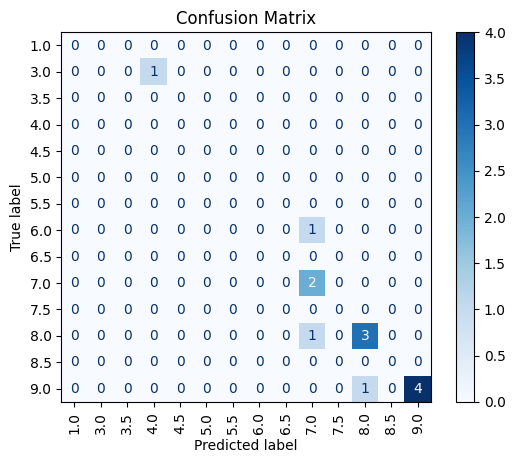

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    true_labels, predicted_labels, labels=list(reverse_mapping.values())
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(reverse_mapping.values())
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")

plt.title("Confusion Matrix")
plt.show()